Autorzy projektu: Sebastian Burniak, Aleksandra Helon, Monika Jachimczyk, Damian Świątek

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.svm import SVC, LinearSVC
from statsmodels.nonparametric.smoothers_lowess import lowess

Wczytano dane

In [2]:
subsc = pd.read_csv('data/subscribers.txt', encoding = "ISO-8859-1", sep='\t')

Dane pogrupowane są w następujących kolumnach

In [3]:
print(subsc.columns.values)

[u'customer_id' u'rate_plan' u'monthly_fee' u'market' u'channel'
 u'start_date' u'stop_date' u'stop_type' u'tenure' u'censored']


In [4]:
subsc.head()

,customer_id,rate_plan,monthly_fee,market,channel,start_date,stop_date,stop_type,tenure,censored
0,2,Top,150.0,Gotham,Dealer,2001-09-16,NaN,NaN,1929.0,1
1,52,Bottom,25.0,Metropolis,Mail,1997-01-13,2004-12-17,V,2895.0,0
2,76,Bottom,25.0,Gotham,Dealer,2000-12-08,2004-10-23,V,1415.0,0
3,89,Bottom,25.0,Gotham,Dealer,1999-09-16,2004-03-18,V,1645.0,0
4,217,Bottom,40.0,Gotham,Dealer,2000-09-04,2004-11-25,I,1543.0,0


Wartości w kolumnie "stop_type" mają następujące wartości:<br>
NULL oznacza ze klient jest aktywny <br>
“I” - “involuntary” czyli odejście po skonczeniu kontraktu<br>
“V” - “voluntary” czyli odejście dobrowolne <br>
“M” - “migration” przejście do innego operatora<br>

In [5]:
subsc.stop_date = subsc.stop_date.fillna(0)

In [6]:
subsc.loc[subsc["stop_date"] == 0, "stop_date"] = "2006-12-28"

In [7]:
subsc = subsc[(subsc.start_date >= '2004-01-01') & (subsc.tenure >= 0)]

In [8]:
subsc.start_date = pd.to_datetime(subsc.start_date)
subsc.stop_date = pd.to_datetime(subsc.stop_date)

In [9]:
subsc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3061719 entries, 918 to 5068034
Data columns (total 10 columns):
customer_id    int64
rate_plan      object
monthly_fee    float64
market         object
channel        object
start_date     datetime64[ns]
stop_date      datetime64[ns]
stop_type      object
tenure         float64
censored       int64
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 256.9+ MB


Tak duża wartość NaN w kolumnie "stop_type" wiąże się z tym że taka liczba klientów jest nadal aktywna.<br>
Uzupełniono brakujące wartości w kolumnie "stop_date" wartością odpowiadającą liczbie dni ("tenure") i jest to data "2006-12-28"

In [10]:
subsc.isnull().sum()

customer_id          0
rate_plan            0
monthly_fee          0
market               0
channel              0
start_date           0
stop_date            0
stop_type      1595299
tenure               0
censored             0
dtype: int64

In [11]:
subsc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3061719 entries, 918 to 5068034
Data columns (total 10 columns):
customer_id    int64
rate_plan      object
monthly_fee    float64
market         object
channel        object
start_date     datetime64[ns]
stop_date      datetime64[ns]
stop_type      object
tenure         float64
censored       int64
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 256.9+ MB


In [12]:
print("Market: ",subsc.market.unique())
print("Rate plan: ",subsc.rate_plan.unique())
print("Channel: ",subsc.channel.unique())
print("Stop type: ",subsc.stop_type.unique())

('Market: ', array([u'Gotham', u'Metropolis', u'Smallville'], dtype=object))
('Rate plan: ', array([u'Bottom', u'Middle', u'Top'], dtype=object))
('Channel: ', array([u'Dealer', u'Store', u'Chain', u'Mail'], dtype=object))
('Stop type: ', array([u'V', nan, u'I', u'M'], dtype=object))


In [13]:
subsc.stop_type = subsc.stop_type.fillna("still_active")

mapping_market = {"Smallville": 1, "Metropolis": 2, "Gotham": 3}
mapping_rate_plan = {"Bottom": 1, "Middle": 2, "Top": 3}
mapping_channel = {"Dealer": 1, "Store": 2, "Channel": 3, "Mail": 4}
mapping_stop_type = {"still_active": 0, "V": 1, "I": 2, "M": 3}

In [14]:
subsc["market"] = subsc["market"].map(mapping_market)
subsc["rate_plan"] = subsc["rate_plan"].map(mapping_rate_plan)
subsc["channel"] = subsc["channel"].map(mapping_channel)
subsc["stop_type"] = subsc["stop_type"].map(mapping_stop_type)
subsc.head(5)

,customer_id,rate_plan,monthly_fee,market,channel,start_date,stop_date,stop_type,tenure,censored
918,50444,1,25.0,3,1.0,2004-08-12,2004-11-01,1,81.0,0
20935,1132991,1,30.0,3,1.0,2004-08-12,2006-12-28,0,868.0,1
30662,1648901,1,20.0,3,1.0,2004-02-10,2006-11-28,1,1022.0,0
39752,2141807,2,60.0,3,1.0,2004-08-12,2006-12-28,0,868.0,1
75895,4076900,1,30.0,3,1.0,2004-08-12,2006-12-28,0,868.0,1


In [15]:
korelacja = subsc.corr("pearson")
korelacja

,customer_id,rate_plan,monthly_fee,market,channel,stop_type,tenure,censored
customer_id,1.000000,-0.054765,-0.037279,-0.073114,0.046234,-0.307400,-0.502345,0.363525
rate_plan,-0.054765,1.000000,0.795959,-0.026823,0.035452,0.095589,0.000997,-0.046531
monthly_fee,-0.037279,0.795959,1.000000,0.018150,-0.027479,0.118490,-0.041237,-0.066087
market,-0.073114,-0.026823,0.018150,1.000000,-0.158233,0.155107,-0.108768,-0.163846
channel,0.046234,0.035452,-0.027479,-0.158233,1.000000,-0.004653,-0.052721,0.053221
stop_type,-0.307400,0.095589,0.118490,0.155107,-0.004653,1.000000,-0.355895,-0.894043
tenure,-0.502345,0.000997,-0.041237,-0.108768,-0.052721,-0.355895,1.000000,0.338841
censored,0.363525,-0.046531,-0.066087,-0.163846,0.053221,-0.894043,0.338841,1.000000


Pary skorelowane najsilniej: <br>
- monthly_fee - rate_plan
- censored - stop_type
- is_active - stop_type
- stop_year - stop_type
- censored - stop_year
- start_year - tenure
- start_year - is_active

In [16]:
korelacja[abs(korelacja)>0.5]

,customer_id,rate_plan,monthly_fee,market,channel,stop_type,tenure,censored
customer_id,1.000000,NaN,NaN,NaN,NaN,NaN,-0.502345,NaN
rate_plan,NaN,1.000000,0.795959,NaN,NaN,NaN,NaN,NaN
monthly_fee,NaN,0.795959,1.000000,NaN,NaN,NaN,NaN,NaN
market,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
channel,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
stop_type,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,-0.894043
tenure,-0.502345,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
censored,NaN,NaN,NaN,NaN,NaN,-0.894043,NaN,1.000000


In [17]:
korelacja[abs(korelacja)<0.1]

,customer_id,rate_plan,monthly_fee,market,channel,stop_type,tenure,censored
customer_id,NaN,-0.054765,-0.037279,-0.073114,0.046234,NaN,NaN,NaN
rate_plan,-0.054765,NaN,NaN,-0.026823,0.035452,0.095589,0.000997,-0.046531
monthly_fee,-0.037279,NaN,NaN,0.018150,-0.027479,NaN,-0.041237,-0.066087
market,-0.073114,-0.026823,0.018150,NaN,NaN,NaN,NaN,NaN
channel,0.046234,0.035452,-0.027479,NaN,NaN,-0.004653,-0.052721,0.053221
stop_type,NaN,0.095589,NaN,NaN,-0.004653,NaN,NaN,NaN
tenure,NaN,0.000997,-0.041237,NaN,-0.052721,NaN,NaN,NaN
censored,NaN,-0.046531,-0.066087,NaN,0.053221,NaN,NaN,NaN


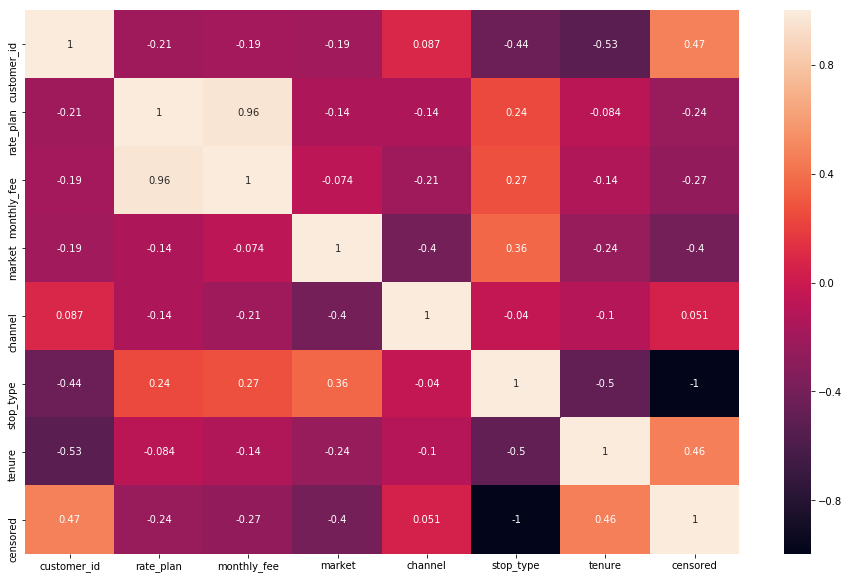

In [18]:
plt.figure(figsize=(16,10))
sns.heatmap(korelacja.corr(), annot=True)
plt.show()

In [19]:
list_of_percentage = []
for i in range(501):
    list_of_percentage.append(100-(len(subsc[subsc.tenure < i])/len(subsc)*100))
list_of_percentage = pd.Series(list_of_percentage)

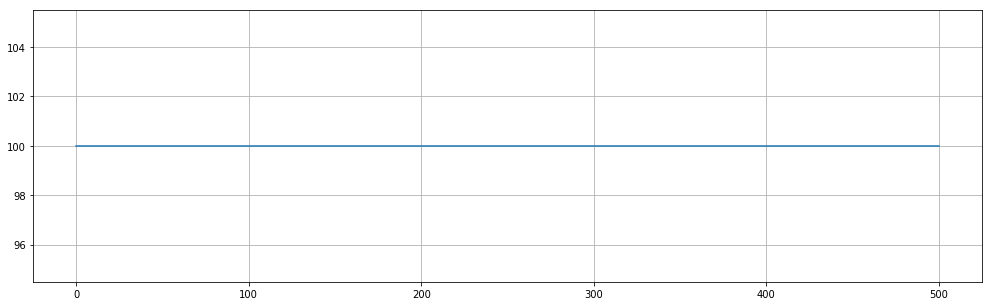

In [20]:
list_of_percentage.plot(y="Tenure",grid=True,figsize=(17,5), use_index=False)

In [21]:
nieaktyw = subsc[(subsc.censored == 0) & (subsc.tenure < 900)]
aktyw = subsc[(subsc.censored == 1) & (subsc.tenure < 900)]

In [22]:
len(nieaktyw)

1449982

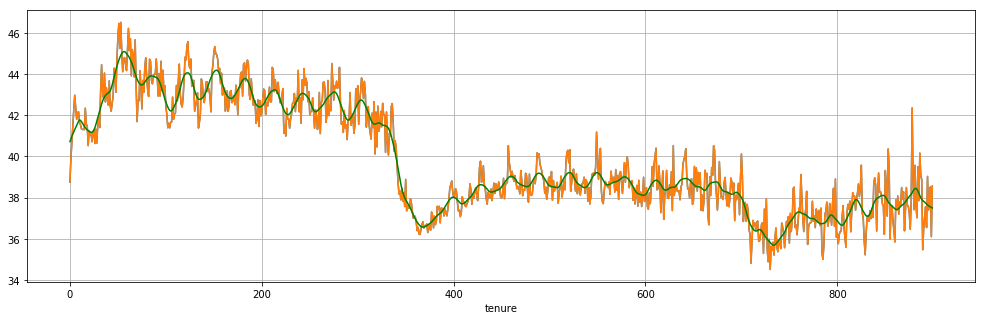

In [23]:
mean_for_nieaktyw = nieaktyw.monthly_fee.groupby(nieaktyw.tenure).mean()
mean_for_nieaktyw.plot(grid=True,figsize=(17,5),)


filtered_nieaktyw = lowess(mean_for_nieaktyw, mean_for_nieaktyw.index, is_sorted=True, frac=0.025, it=0)
plt.plot(mean_for_nieaktyw.index, mean_for_nieaktyw)
plt.plot(filtered_nieaktyw[:,0], filtered_nieaktyw[:,1], 'g')

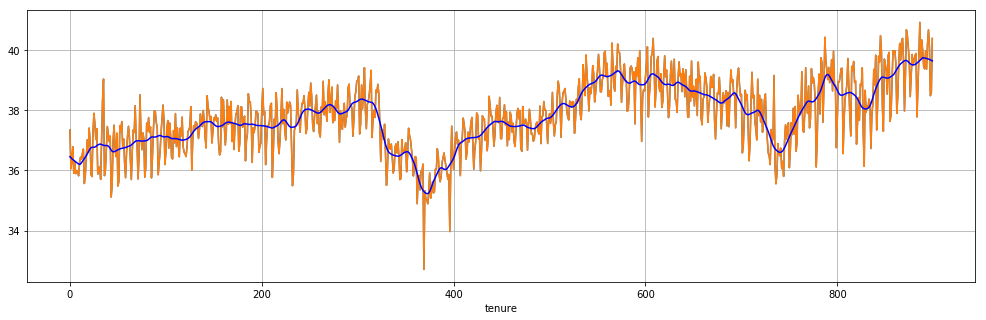

In [24]:
mean_for_aktyw = aktyw.monthly_fee.groupby(aktyw.tenure).mean()
mean_for_aktyw.plot(grid=True,figsize=(17,5))

filtered_aktyw = lowess(mean_for_aktyw, mean_for_aktyw.index, is_sorted=True, frac=0.025, it=0)
plt.plot(mean_for_aktyw.index, mean_for_aktyw)
plt.plot(filtered_aktyw[:,0], filtered_aktyw[:,1], 'b')

In [25]:
pop = subsc.tenure.groupby(subsc.tenure).count()
numstops = subsc.groupby(subsc.tenure).count()["stop_type"]
mfsumall = subsc.monthly_fee.groupby(subsc.tenure).sum()
mfsumstop = numstops * mean_for_nieaktyw

In [26]:
print(pop[0],numstops[0], mfsumall[0], mfsumstop[0])
print(mfsumall[0]/pop[0], mfsumstop[0]/numstops[0])

(2383, 2383, 89712.0, 92350.63188976378)
(37.6466638690726, 38.753937007874015)


In [27]:
tablica = [pop, numstops, mfsumall, mfsumstop]
nowa_df = pd.concat(tablica, axis=1)

In [28]:
nowa_df.columns = ['pop','numstops','mfsumall','mfsumstop']
nowa_df["stops_mf"] = nowa_df.mfsumstop/nowa_df.numstops

In [29]:
lista_list = []
revv = nowa_df.iloc[::-1]
for index, row in revv.iterrows():
    try:
        lista_list.append(row['pop']+lista_list[-1])
    except IndexError:
        lista_list.append(row['pop']+ 0)
lista_list = lista_list[::-1]

In [30]:
nowa_df["popatrisk"] = pd.Series(lista_list)
nowa_df["actives"] = nowa_df["popatrisk"] - nowa_df["numstops"]
nowa_df["STOPS"] = nowa_df["numstops"]

In [31]:
list_list = []
for index, row in nowa_df.iterrows():
    list_list.append(sum(nowa_df.mfsumall[index:]) - row["mfsumstop"])
nowa_df["sum_mf"] = pd.Series(list_list)

In [32]:
nowa_df["actives_mf"] = nowa_df.sum_mf/nowa_df.actives

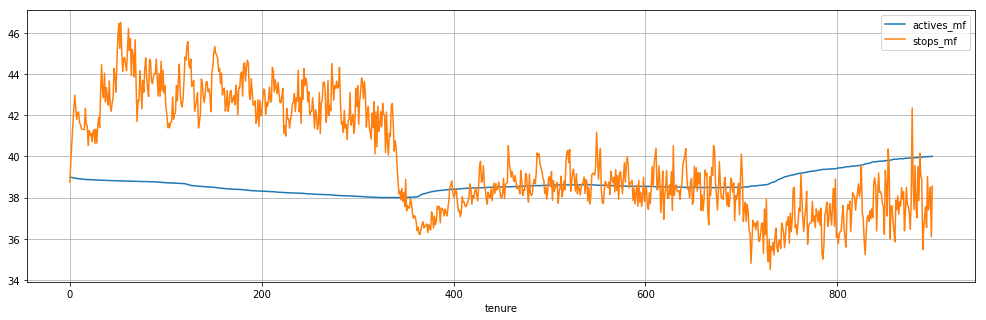

In [33]:
nowa_df[["actives_mf","stops_mf"]].plot(grid=True,figsize=(17,5))

In [34]:
subsc.head(2)

,customer_id,rate_plan,monthly_fee,market,channel,start_date,stop_date,stop_type,tenure,censored
918,50444,1,25.0,3,1.0,2004-08-12,2004-11-01,1,81.0,0
20935,1132991,1,30.0,3,1.0,2004-08-12,2006-12-28,0,868.0,1


In [35]:
#pd.Timestamp('2006-02-14') - subsc.start_date == pd.Timedelta('365 days')

In [42]:
naked = subsc[((subsc.stop_date >= '2006-02-14') | (subsc.stop_date.isnull())) & (pd.Timestamp('2006-02-14') - subsc.start_date == pd.Timedelta('365 days'))]
ct = subsc[((subsc.start_date > '2004-01-01') & (subsc.tenure >= 0)) & ((subsc.stop_date >= '2006-02-14') | (subsc.stop_date.isnull())) & (pd.Timestamp('2006-02-14') - subsc.start_date == pd.Timedelta('365 days'))].count()
b = naked.stop_date == '2006-02-14'
#naked.loc[:, b]
naked['s365'] = np.where((naked.stop_date == '2006-02-14'), 1,0)
naked['h365'] = np.where((naked.stop_date == '2006-02-14'), 1,0)
#dir(h365)
naked

D:\anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
D:\anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,customer_id,rate_plan,monthly_fee,market,channel,start_date,stop_date,stop_type,tenure,censored,s365,h365
2245289,90955414,3,100.0,2,2.0,2005-02-14,2006-12-28,0,682.0,1,0,0
3169674,97249426,3,100.0,2,2.0,2005-02-14,2006-12-28,0,682.0,1,0,0
3263344,98052115,1,35.0,1,2.0,2005-02-14,2006-12-28,0,682.0,1,0,0
3263345,98052116,1,35.0,1,2.0,2005-02-14,2006-12-28,0,682.0,1,0,0
3278378,98171895,1,30.0,1,2.0,2005-02-14,2006-11-16,1,640.0,0,0,0
3280504,98176627,1,40.0,3,1.0,2005-02-14,2006-12-22,1,676.0,0,0,0
3286760,98233048,1,35.0,2,NaN,2005-02-14,2006-12-28,0,682.0,1,0,0
3286762,98233050,2,60.0,2,2.0,2005-02-14,2006-12-28,0,682.0,1,0,0
3286764,98233053,1,30.0,2,2.0,2005-02-14,2006-12-28,0,682.0,1,0,0
3286765,98233054,1,40.0,2,NaN,2005-02-14,2006-12-28,0,682.0,1,0,0


In [48]:
naked.info

<bound method DataFrame.info of          customer_id  rate_plan  monthly_fee  market  channel start_date  \
2245289     90955414          3        100.0       2      2.0 2005-02-14   
3169674     97249426          3        100.0       2      2.0 2005-02-14   
3263344     98052115          1         35.0       1      2.0 2005-02-14   
3263345     98052116          1         35.0       1      2.0 2005-02-14   
3278378     98171895          1         30.0       1      2.0 2005-02-14   
3280504     98176627          1         40.0       3      1.0 2005-02-14   
3286760     98233048          1         35.0       2      NaN 2005-02-14   
3286762     98233050          2         60.0       2      2.0 2005-02-14   
3286764     98233053          1         30.0       2      2.0 2005-02-14   
3286765     98233054          1         40.0       2      NaN 2005-02-14   
3286766     98233056          1         30.0       2      NaN 2005-02-14   
3286767     98233057          1         30.0       2    